# MNIST Convolutional Neural Network - 2nd model
Gaetano Bonofiglio, Veronica Iovinella

This time we are going to implement a model similar to the one used by Dan Ciresan, Ueli Meier and Jurgen Schmidhuber in 2012. The model should have an error of 0.23% and it's quite similar to the previous one we implemented from Keras documentation. The network was not only one of the best for MNIST, ranking second best at the moment, but also very good on NIST SD 19 and NORB. 

We are also going to use Keras checkpoints because of the many epochs required by the model and we're going to integrate some of the most recent techniques, like dropout.

Again for this notebook we are going to use **TensorFlow** with **Keras**.

In [1]:
import tensorflow as tf 
# We don't really need to import TensorFlow here since it's handled by Keras, 
# but we do it in order to output the version we are using.

In [2]:
tf.__version__

'0.12.1'

We are using TensorFlow-GPU 0.12.1 on Python 3.5.2, running on Windows 10 with Cuda 8.0. 

We have 3 machines with the same environment and 3 different GPUs, respectively with 384, 1024 and 1664 Cuda cores.

## Imports

In [3]:
import os.path
from IPython.display import Image

from util import Util
u = Util()

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)  

Using TensorFlow backend.


In [4]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [5]:
from keras.datasets import mnist

## Definitions

In [6]:
batch_size = 512
nb_classes = 10
nb_epoch = 800
# checkpoint path
checkpoints_filepath_tanh = "checkpoints/02_MNIST_tanh_weights.best.hdf5"
checkpoints_filepath_relu = "checkpoints/02_MNIST_relu_weights.best.hdf5"
# model image path
model_image_path = 'images/model_02_MNIST.png' # saving only relu

In [7]:
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters1 = 20
nb_filters2 = 40
# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dense layer size
dense_layer_size1 = 150
# dropout rate
dropout = 0.15

## Data load

In [8]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

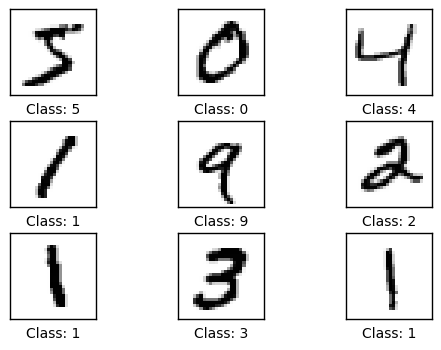

In [9]:
u.plot_images(X_train[0:9], y_train[0:9])

In [10]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [12]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Model definition
The model is structurally similar to the previous one, with 2 Convolutional layers and 1 Fully conneted layers. 
However there are major difference in values and sizes, and also there is one more intermediate max pooling layer and the activation function is a scaled hyperbolic tangent, as described in the [paper](http://people.idsia.ch/~ciresan/data/cvpr2012.pdf). However, since Rectified Linear Units started spreading after 2015, we are going to compare two different CNN, one using tanh (as in the paper) and the other one using relu. 

**1x29x29-20C4-MP2-40C5-MP3-150N-10N DNN**.
<img src="images/cvpr2012.PNG" alt="1x29x29-20C4-MP2-40C5-MP3-150N-10N DNN" style="width: 400px;"/>

The paper doesn't seem to use any dropout layer to avoid overfitting, so we're going to use a dropout of 0.15, way lower then we did before. 
It is also worth mentioning that the authors of the paper have their methods to avoid overfitting, like dataset expansion by adding translations, rotations and deformations to the images of the training set. 

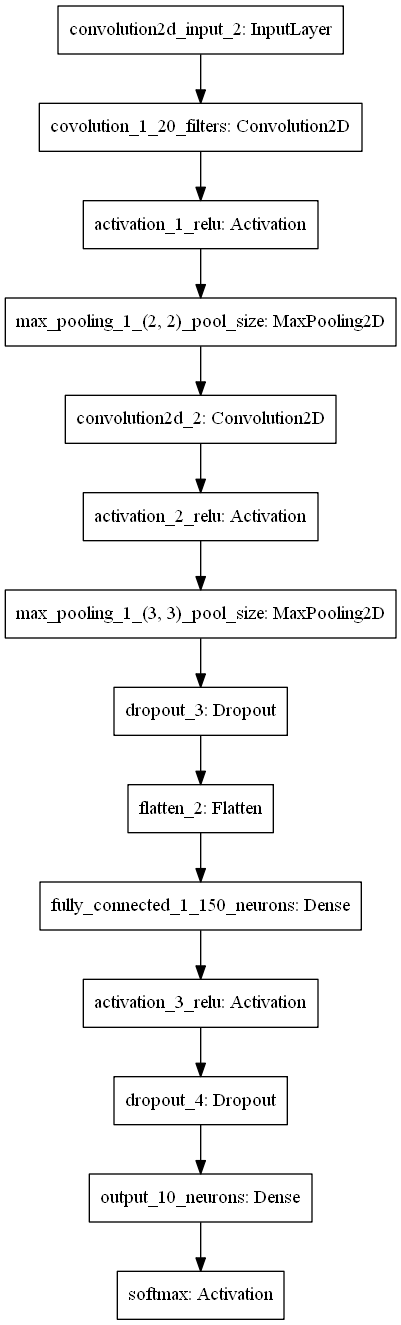

In [13]:
model_tanh = Sequential()
model_relu = Sequential()

def initialize_network_with_activation_function(model, activation, checkpoints_filepath):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall', 'mean_absolute_error'])
    
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    
initialize_network_with_activation_function(model_tanh, 'tanh', checkpoints_filepath_tanh)
initialize_network_with_activation_function(model_relu, 'relu', checkpoints_filepath_relu)

Image(u.maybe_save_network(model_relu, model_image_path), width=300)

## Training and evaluation
Using non verbose output for training, since we already get some informations from the callback. 

In [14]:
# checkpoint
checkpoint_tanh = ModelCheckpoint(checkpoints_filepath_tanh, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_tanh = [checkpoint_tanh]

# training
print('training tanh model')
history_tanh = model_tanh.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list_tanh)
# evaluation
print('evaluating tanh model')
score = model_tanh.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')

training tanh model
Epoch 00000: val_acc improved from -inf to 0.92540, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00001: val_acc improved from 0.92540 to 0.94730, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00002: val_acc improved from 0.94730 to 0.96490, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00003: val_acc improved from 0.96490 to 0.96510, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00004: val_acc improved from 0.96510 to 0.97190, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00005: val_acc improved from 0.97190 to 0.97610, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00006: val_acc improved from 0.97610 to 0.97640, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00007: val_acc improved from 0.97640 to 0.97780, saving model to checkpoints/02_MNIST_tanh_weights.best.hdf5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc impro

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


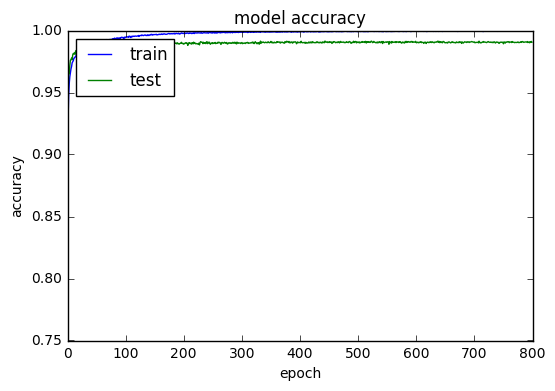

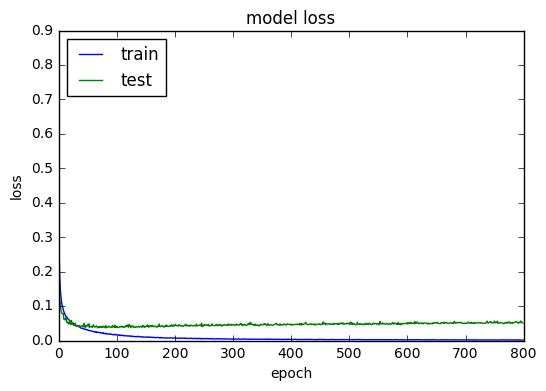

In [15]:
u.plot_history(history_tanh)
u.plot_history(history_tanh, metric='loss', loc='upper left')

In [16]:
# checkpoint
checkpoint_relu = ModelCheckpoint(checkpoints_filepath_relu, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_relu = [checkpoint_relu]

# training
print('training relu model')
history_relu = model_relu.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list_relu)

# evaluation
print('evaluating relu model')
score = model_relu.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test error:', (1-score[2])*100, '%')

training relu model
Epoch 00000: val_acc improved from -inf to 0.92650, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00001: val_acc improved from 0.92650 to 0.95220, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00002: val_acc improved from 0.95220 to 0.96720, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00003: val_acc improved from 0.96720 to 0.97210, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00004: val_acc improved from 0.97210 to 0.97700, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc improved from 0.97700 to 0.97940, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00007: val_acc improved from 0.97940 to 0.98150, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00008: val_acc improved from 0.98150 to 0.98350, saving model to checkpoints/02_MNIST_relu_weights.best.hdf5
Epoch 00009: val_acc impro

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


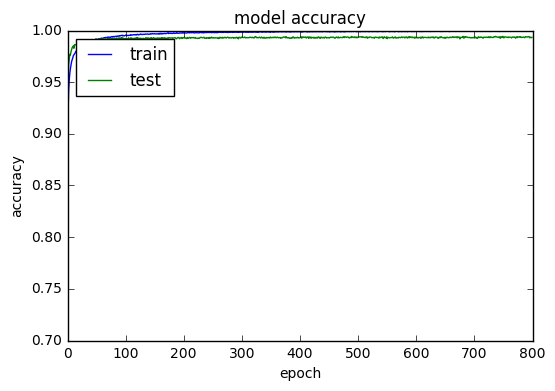

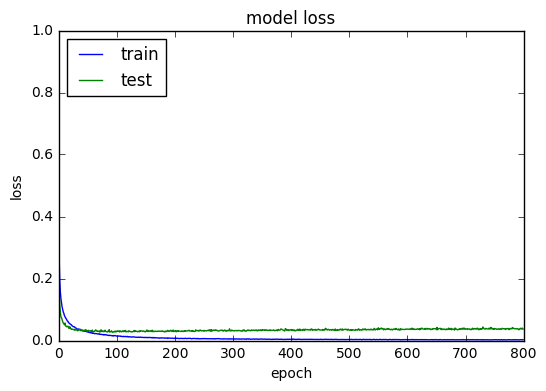

In [17]:
u.plot_history(history_relu)
u.plot_history(history_relu, metric='loss', loc='upper left')

## Inspecting the result

In [18]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes_tanh = model_tanh.predict_classes(X_test)
predicted_classes_relu = model_relu.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices_tanh = np.nonzero(predicted_classes_tanh == y_test)[0]
incorrect_indices_tanh = np.nonzero(predicted_classes_tanh != y_test)[0]

correct_indices_relu = np.nonzero(predicted_classes_relu == y_test)[0]
incorrect_indices_relu = np.nonzero(predicted_classes_relu != y_test)[0]

 9952/10000 [============================>.] - ETA: 0s

### Examples of correct predictions (tanh)

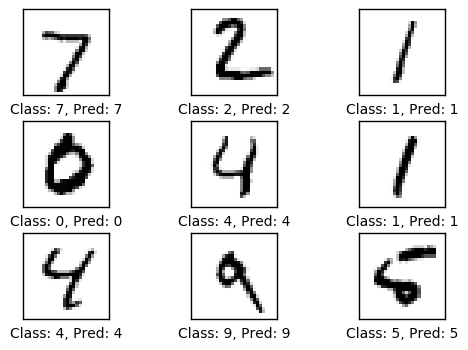

In [19]:
u.plot_images(X_test[correct_indices_tanh[:9]], y_test[correct_indices_tanh[:9]], 
              predicted_classes_tanh[correct_indices_tanh[:9]])

### Examples of incorrect predictions (tanh)

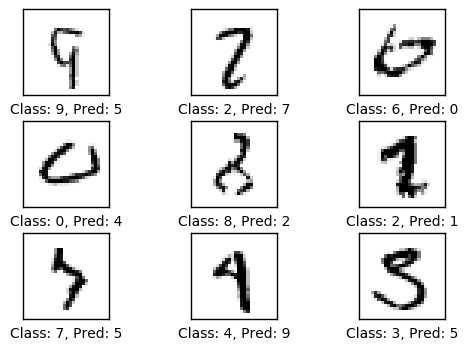

In [20]:
u.plot_images(X_test[incorrect_indices_tanh[:9]], y_test[incorrect_indices_tanh[:9]], 
              predicted_classes_tanh[incorrect_indices_tanh[:9]])

### Examples of correct predictions (relu)

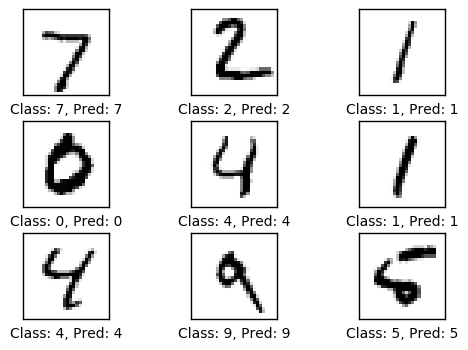

In [21]:
u.plot_images(X_test[correct_indices_relu[:9]], y_test[correct_indices_relu[:9]], 
              predicted_classes_relu[correct_indices_relu[:9]])

### Examples of incorrect predictions (relu)

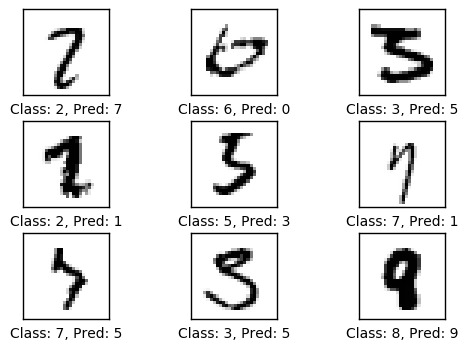

In [22]:
u.plot_images(X_test[incorrect_indices_relu[:9]], y_test[incorrect_indices_relu[:9]], 
              predicted_classes_relu[incorrect_indices_relu[:9]])

### Confusion matrix (tanh)

[[ 971    1    0    0    2    2    2    1    0    1]
 [   0 1130    1    3    0    0    0    1    0    0]
 [   1    1 1022    0    1    0    0    7    0    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    0    0  975    0    1    0    0    6]
 [   1    0    0    5    0  884    1    1    0    0]
 [   3    2    0    1    2    2  946    0    2    0]
 [   0    3    6    0    0    1    0 1017    0    1]
 [   0    0    1    1    0    0    1    2  966    3]
 [   3    0    1    0    5    4    0    4    3  989]]


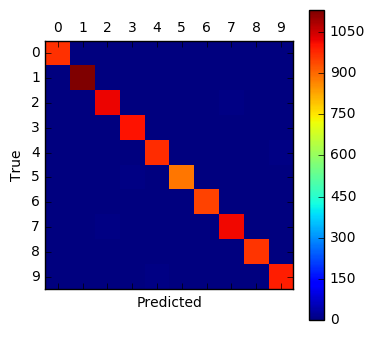

In [23]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_tanh)

### Confusion matrix (relu)

[[ 974    0    1    0    0    1    1    2    1    0]
 [   0 1134    0    0    0    0    0    1    0    0]
 [   1    1 1020    2    0    0    1    7    0    0]
 [   0    0    1 1005    0    2    0    2    0    0]
 [   0    0    0    0  980    0    0    0    0    2]
 [   0    0    0    5    0  885    1    1    0    0]
 [   2    2    0    0    2    2  948    0    2    0]
 [   0    3    1    1    0    1    0 1021    1    0]
 [   0    0    0    0    1    0    0    1  971    1]
 [   1    0    0    0    7    1    0    3    1  996]]


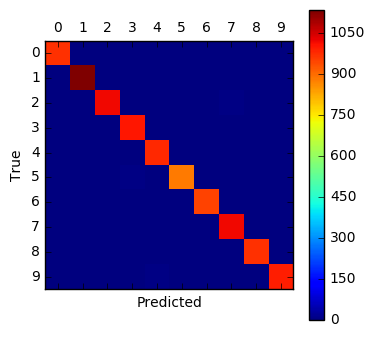

In [24]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes_relu)

## Results
We experimented with 2 CNN models, identical in every aspect except the activation function, one used "tanh" and the other "relu". After 800 epochs running in about 2 seconds each (on GTX 970), we observed both models resulted in overfitting. Looking at the graphs, we noticed that a good number of epochs to choose to save time is about 50. In particular in this case relu presented a better behaviour than tanh which degrades earlier after 40 epochs, in contrast to the 56 epochs of relu. The results obtained after 800 epochs have higher precision (as we will see in the next notebook), the time it takes to train the network is not worth the increase. 